In [4]:
import zipfile
import os

# Path to the uploaded zip file
zip_file_path = '/content/archive (10).zip'

# Directory where you want to extract the files
extraction_dir = 'Images'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)


In [5]:
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os

# Read the CSV file into a DataFrame
csv_file_path = os.path.join(extraction_dir, 'english.csv')
df = pd.read_csv(csv_file_path)

# Initialize a label encoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numeric values
labels_encoded = label_encoder.fit_transform(df['label'])

# Update DataFrame with encoded labels
df['label'] = labels_encoded

# Define image directory
image_dir = os.path.join(extraction_dir, 'Img/')

# Initialize empty arrays for images and labels
images = []
labels = []

# Load and preprocess images
for index, row in df.iterrows():
    class_number = int(row['label']) + 1  # Increment class number by 1 to match filename convention
    image_index = index % 55 + 1  # Wrap the index within the range [1, 55]
    image_filename = f'img{str(class_number).zfill(3)}-{str(image_index).zfill(3)}.png'
    image_path = os.path.join(image_dir, image_filename)
    image = Image.open(image_path)
    # Convert image to grayscale
    image = image.convert('L')
    # Resize and preprocess the image as needed
    image = image.resize((28, 28))  # Example resizing to 28x28 pixels
    image = np.array(image) / 255.0  # Normalize pixel values
    images.append(image)
    labels.append(row['label'])

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Print shapes to verify
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)


Train images shape: (2728, 28, 28)
Train labels shape: (2728,)
Test images shape: (682, 28, 28)
Test labels shape: (682,)


In [7]:
pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [11]:
from kerastuner import RandomSearch
from tensorflow import keras
from tensorflow.keras import layers

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(62, activation='softmax'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Tune the optimizer
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])

    # Compile the model
    model.compile(optimizer=hp_optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='handwriting_recognition_v2'
)

# Perform hyperparameter search
tuner.search(train_images, train_labels, epochs=20, validation_data=(test_images, test_labels))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best optimizer: {best_hps.get('optimizer')}")
#print(f"Best batch size: {best_hps.get('batch_size')}")

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

# Save the trained model
model.save('model.h5')

Trial 5 Complete [00h 28m 10s]
val_accuracy: 0.6920821070671082

Best val_accuracy So Far: 0.7033235430717468
Total elapsed time: 02h 18m 15s
Best learning rate: 0.01
Best optimizer: rmsprop
Epoch 1/10
86/86 [==============================] - 27s 310ms/step - loss: 4.1339 - accuracy: 0.0220 - val_loss: 4.0674 - val_accuracy: 0.0367
Epoch 2/10
86/86 [==============================] - 26s 306ms/step - loss: 3.4033 - accuracy: 0.1606 - val_loss: 2.8946 - val_accuracy: 0.2522
Epoch 3/10
86/86 [==============================] - 25s 296ms/step - loss: 2.0419 - accuracy: 0.4538 - val_loss: 2.0442 - val_accuracy: 0.4531
Epoch 4/10
86/86 [==============================] - 28s 327ms/step - loss: 1.3847 - accuracy: 0.6184 - val_loss: 1.5753 - val_accuracy: 0.5630
Epoch 5/10
86/86 [==============================] - 27s 312ms/step - loss: 1.0093 - accuracy: 0.7067 - val_loss: 1.7946 - val_accuracy: 0.5616
Epoch 6/10
86/86 [==============================] - 26s 308ms/step - loss: 0.7801 - accuracy: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 85ms/step


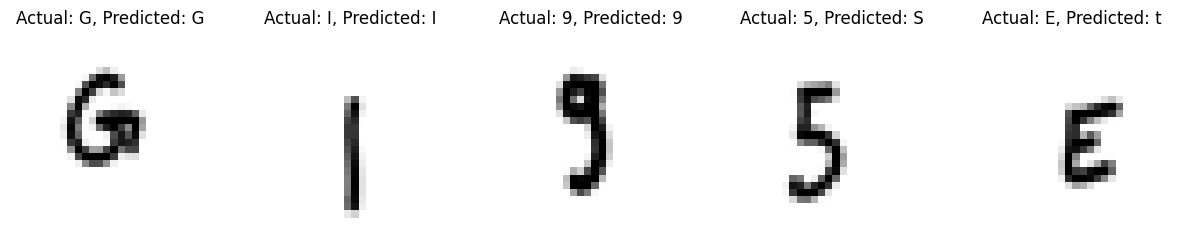

In [57]:
import matplotlib.pyplot as plt
import random

# Define a mapping from class numbers to letters
class_to_letter = {
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z',
    36: 'a', 37: 'b', 38: 'c', 39: 'd', 40: 'e', 41: 'f', 42: 'g', 43: 'h', 44: 'i', 45: 'j', 46: 'k', 47: 'l', 48: 'm', 49: 'n', 50: 'o', 51: 'p', 52: 'q', 53: 'r', 54: 's', 55: 't', 56: 'u', 57: 'v', 58: 'w', 59: 'x', 60: 'y', 61: 'z'
}
# Select 5 random indices from the test data
random_indices = random.sample(range(len(test_images)), 5)

# Get the corresponding images and labels
selected_images = [test_images[i] for i in random_indices]
selected_labels = [test_labels[i] for i in random_indices]

# Make predictions using the trained model
predicted_labels = model.predict(np.array(selected_images))

# Display the selected images along with their predicted and actual labels
display_images(selected_images, selected_labels, predicted_labels)


In [21]:
print(class_to_letter.keys())


dict_keys([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85])


22/22 [==============================] - 2s 70ms/step
Accuracy: 0.5997067448680352


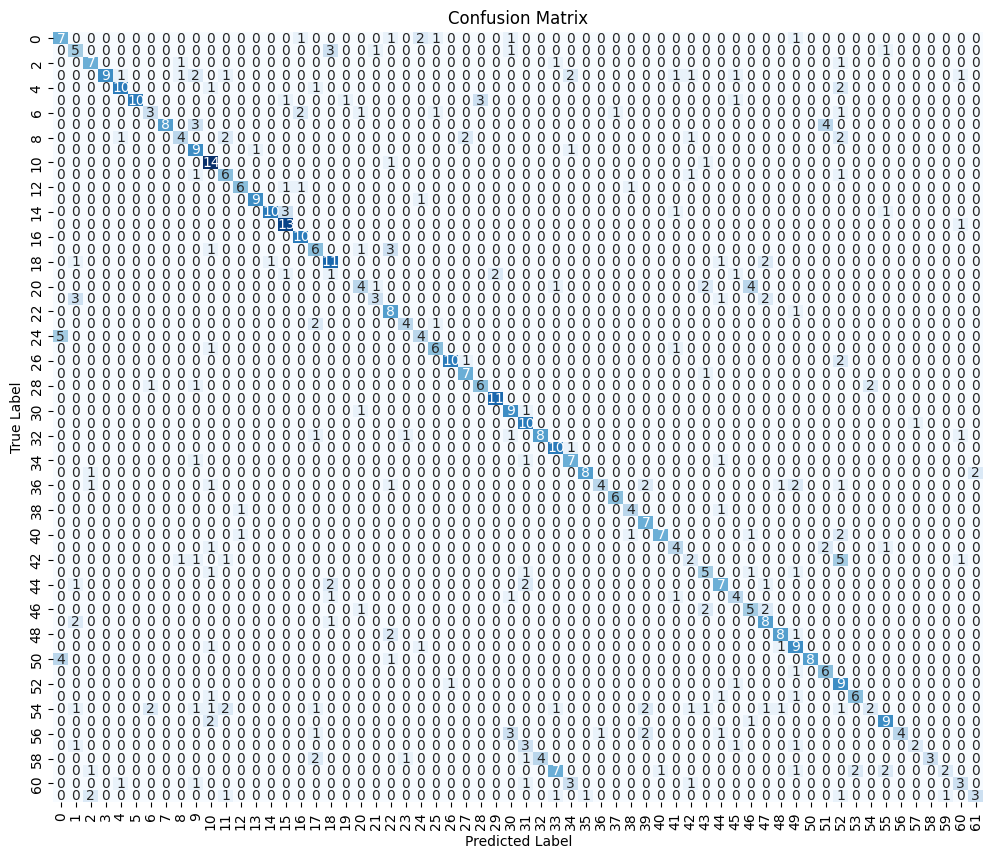

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels for test images
predicted_labels = model.predict(test_images)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_labels)
print("Accuracy:", accuracy)

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [41]:
import tensorflow as tf
import keras
import numpy as np
import cv2

In [48]:
def preprocess_custom_image(image_path):
    # Load the custom image
    custom_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize the image to match the input size of the model
    custom_image = cv2.resize(custom_image, (32, 32))

    # Normalize pixel values
    custom_image = custom_image / 255.0

    return custom_image

def predict_custom_image(image_path):
    # Preprocess the custom image
    custom_image = preprocess_custom_image(image_path)

    # Make prediction using the trained model
    predicted_label = model.predict(np.array([custom_image]))

    # Decode the predicted label
    decoded_label = label_binarizer.inverse_transform(predicted_label)

    # Map the class number to the corresponding letter
    predicted_letter = class_to_letter[decoded_label[0]]

    return predicted_letter

# Provide the path to the custom image
custom_image_path = "/content/test2.png"

# Predict the custom image
predicted_letter = predict_custom_image(custom_image_path)

# Display the predicted letter
print("Predicted Letter:", predicted_letter)

InvalidArgumentError: Graph execution error:

Detected at node sequential_1/dense_2/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-40-8b403e56a09f>", line 36, in <cell line: 36>

  File "<ipython-input-40-8b403e56a09f>", line 22, in predict_custom_image

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2655, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py", line 255, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/activations.py", line 306, in relu

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5395, in relu

Matrix size-incompatible: In[0]: [1,18432], In[1]: [12800,128]
	 [[{{node sequential_1/dense_2/Relu}}]] [Op:__inference_predict_function_179376]

In [58]:
import cv2
import numpy as np
import os

# Define the function to split the word image into individual character images using contour detection
def split_word_into_characters(word_image_path, output_dir):
    # Read the word image
    word_image = cv2.imread(word_image_path, cv2.IMREAD_GRAYSCALE)

    # Apply thresholding to segment the characters
    _, thresh = cv2.threshold(word_image, 127, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours from left to right
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

    # Iterate through each contour and extract individual characters
    character_image_paths = []
    for i, contour in enumerate(contours):
        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(contour)

        # Extract individual character
        char_image = word_image[y:y+h, x:x+w]

        # Save the character image
        char_image_path = os.path.join(output_dir, f'char_{i}.png')
        cv2.imwrite(char_image_path, char_image)
        character_image_paths.append(char_image_path)

    return character_image_paths

# Define the function to preprocess and predict the label for a character image
def predict_character(character_image_path, model):
    # Load and preprocess the character image
    char_image = cv2.imread(character_image_path, cv2.IMREAD_GRAYSCALE)
    char_image = cv2.resize(char_image, (28, 28))  # Resize to match model input shape
    char_image = np.expand_dims(char_image, axis=0)  # Add batch dimension
    char_image = np.expand_dims(char_image, axis=-1)  # Add channel dimension
    char_image = char_image.astype('float32') / 255.0  # Normalize pixel values

    # Predict the label for the character image using the model
    predicted_label = model.predict(char_image)

    return predicted_label

# Define the function to predict the word from a word image
def predict_word(input_word_image_path, model):
    # Create output directory for character images
    output_dir = 'output_characters'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Split the word image into individual character images
    character_image_paths = split_word_into_characters(input_word_image_path, output_dir)

    # Predict the label for each character image and concatenate the labels to form the predicted word
    predicted_word = ''
    for char_image_path in character_image_paths:
        predicted_label = predict_character(char_image_path, model)
        predicted_char = chr(np.argmax(predicted_label) + 48)  # Convert label to character (assuming labels are integers)
        predicted_word += predicted_char

    return predicted_word

# Example usage
input_word_image_path = '/content/test_img (1).png'  # Provide the path to the word image
predicted_word = predict_word(input_word_image_path, model)
print('Predicted Word:', predicted_word)


1/1 [==============================] - 0s 23ms/step
Predicted Word: \``F\Xg\eU[KTl;\\ZQOQT;
